This notebook includes the work I developed as a submission for the Kaggle Titanic competition. 

Developed by Ahmed Kayal

#### Package imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### File read

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [3]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# %load functions.py 
"""

 -- The following set of functions were provided to me by dataquest.io but include some personal edits -- 

"""
def process_missing(df):
    """
    Handle various missing values from the data set

    :param df: Input dataframe with columns containing missing values
    :type df: 'pandas.DataFrame'
    """
    
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """
    Process the Age column into pre-defined 'bins' 

    :param df: Input dataframe with uncategorized age column 
    :type df: 'pandas.DataFrame'
    """
    
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """
    Process the Fare column into pre-defined 'bins' 

    :param df: Input dataframe with uncategorized Fare column 
    :type df: 'pandas.DataFrame'
    """
    
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """
    Process the Cabin column into pre-defined 'bins' 

    :param df: Input dataframe with unadjusted Cabin column 
    :type df: 'pandas.DataFrame'
    """
    
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """
    Extract and categorize the title from the name column 

    :param df: Input dataframe with unadjusted Name column and no Title column
    :type df: 'pandas.DataFrame'
    """
    
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df, column_name):
    """
    Create Dummy Columns (One Hot Encoding) from a single Column

    :param df: Input dataframe with continuous values for each feature
    :type df: 'pandas.DataFrame'
    :param column_name: Name of column to one-hot encoded
    :type column_name: str
    """
    
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

<br>

##### Creating final_function in order to quickly execute all of the recently loaded functions. 

In [5]:
def final_processing(df):
    # Processing functions
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    # One hot encoding functions
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    
    return df


In [6]:
modified_train = final_processing(train)
modified_holdout = final_processing(holdout)

In [7]:
print(modified_train.shape, '\n', modified_holdout.shape)

(891, 43) 
 (418, 41)


<br>

### EDA of titanic data

We'll take a particular interest in the following columns:

SibSp - # of siblings / spouses aboard the Titanic	
parch - # of parents / children aboard the Titanic


In [8]:
modified_train.dtypes[["SibSp", "Parch"]]

SibSp    int64
Parch    int64
dtype: object

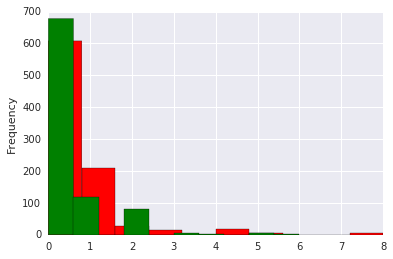

In [9]:
%matplotlib inline
modified_train["SibSp"].plot.hist(color='red')
modified_train["Parch"].plot.hist(color='green')

In [10]:
modified_train["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [11]:
modified_train["family_count"] = modified_train["SibSp"] + modified_train["Parch"]
modified_holdout["family_count"] = modified_holdout["SibSp"] + modified_holdout["Parch"]


In [12]:
comparison_df = pd.DataFrame()

comparison_df["SibSp_survival_rate"] = pd.pivot_table(data=modified_train, index="SibSp")["Survived"]
comparison_df["Parch_survival_rate"] = pd.pivot_table(data=modified_train, index="Parch")["Survived"]
comparison_df["family_count_survival_rate"] = pd.pivot_table(data=modified_train, index="family_count")["Survived"]


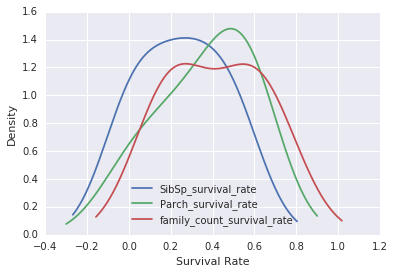

In [13]:
comparison_df["SibSp_survival_rate"].plot.kde(legend=True)
comparison_df["Parch_survival_rate"].plot.kde(legend=True)
comparison_df["family_count_survival_rate"].plot.kde(legend=True)
plt.xlabel("Survival Rate")

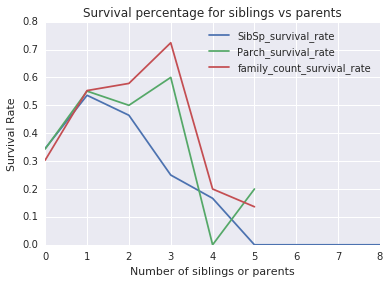

In [14]:
comparison_df["SibSp_survival_rate"].plot(legend=True)
comparison_df["Parch_survival_rate"].plot(legend=True)
comparison_df["family_count_survival_rate"].plot(legend=True)
plt.ylabel("Survival Rate")
plt.xlabel("Number of siblings or parents")
plt.title("Survival percentage for siblings vs parents")

**Conclusion**

Reviewing the survival rates associated with each column, individuals with a greater number of siblings had a higher rate of survival if they had more siblings as compared to having more parents onboard with them. Furthermore, the individuals on the ship that had zero siblings or parents had a much lower rate of survival compared to those that had at least one family member. 

<br>

#### Engineering new features

In [15]:
def is_alone(df):
    """
    Adds a new column, isalone that has the value 0 if the 
    passenger has one or more family members onboard, and 
    1 if the passenger has zero family members onboard.
    
    :param df: Input dataframe 
    :type df: 'pandas.DataFrame'
    """
    
    df["isalone"] = np.where(df['family_count'] > 0, 0, 1)
    return df

In [16]:
modified_train_v2 = is_alone(modified_train)
modified_holdout_v2 = is_alone(modified_holdout)
modified_train["isalone"].head()

0    0
1    0
2    1
3    0
4    1
Name: isalone, dtype: int64

In [17]:
modified_train_v2.shape

(891, 45)

In [18]:
def select_features(df):
    """
    Performs data preparation for modeling step.
    Uses recursive feature elimination and the random 
    forests algorithm to find the best-performing set of 
    features.
    
    :param df: Input dataframe
    :type df: 'pandas.DataFrame'
    """
    
    df = df.dropna(axis=1, how='all')
    df = df.select_dtypes(exclude=["category", "object"])
    
    all_X = df.drop(columns=["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    
    print("List of selected features: ", optimized_columns)
    return optimized_columns


In [19]:
train_optimized_features = select_features(modified_train_v2)

List of selected features:  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'family_count', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



Creating a model training function that will loop through a set of models to train them and will indicate which performed best by noting the best performing scores within a parameter dictionary. 

In [20]:
def select_model(df, feature_list, target_column):
    """
    Breaks the dataframe down and loops through three models to 
    find the best performing parameters and scores
    """
    all_X = df[feature_list]
    all_y = df[target_column]
    
    model_dict = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters": 
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
        }
    ]
    
    
    for item in model_dict:
        print('*'*5, item['name'], '*'*5)
        grid = GridSearchCV(item['estimator'], item["hyperparameters"], cv=10)
        grid.fit(all_X, all_y)
        
        item["best_params"] = grid.best_params_
        item["best_score"] = grid.best_score_
        print(item["best_params"], item["best_score"], '\n\n')
        item["best_model"] = grid.best_estimator_
    
    return model_dict



In [21]:
modified_train_v2_modeling_results = select_model(modified_train_v2, train_optimized_features, "Survived")


***** LogisticRegression *****
{'solver': 'newton-cg'} 0.8181818181818182 


***** KNeighborsClassifier *****
{'algorithm': 'kd_tree', 'p': 1, 'weights': 'uniform', 'n_neighbors': 3} 0.7800224466891134 


***** RandomForestClassifier *****
{'min_samples_leaf': 1, 'n_estimators': 9, 'max_depth': 10, 'min_samples_split': 5, 'max_features': 'sqrt', 'criterion': 'entropy'} 0.8383838383838383 




To make predicting and saving model scores easier, another function will be created to do just that.

In [22]:
def save_submission_file(df, model, cols, filename):
    """
    Generates a pandas DataFrame of model predictions and saves output as a CSV file
    
    :param df: 'pandas.DataFrame'
    :param model: Trained model to be used for predictions
    :param cols: List of features to be used as model input
    :param filename: Name given to score file 
    :return: CSV file of scores
    """
    
    predictions = model.predict(df[cols])
    results = pd.DataFrame()
    results["PassengerId"] = df["PassengerId"]
    results["Survived"] = predictions
    
    results.to_csv(filename, index=False)
    

In [23]:
modified_holdout_v2.shape

(418, 43)

#### Generating output

In [24]:
save_submission_file(modified_holdout_v2, modified_train_v2_modeling_results[2]["best_model"], train_optimized_features, "third_round_submission.csv")
